In [2]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5565, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 5563, 32)     128         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 2781, 32)     0           ['conv1d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 2781, 32)     0           ['max_pooling1d[0][0]']          
                                                                                              

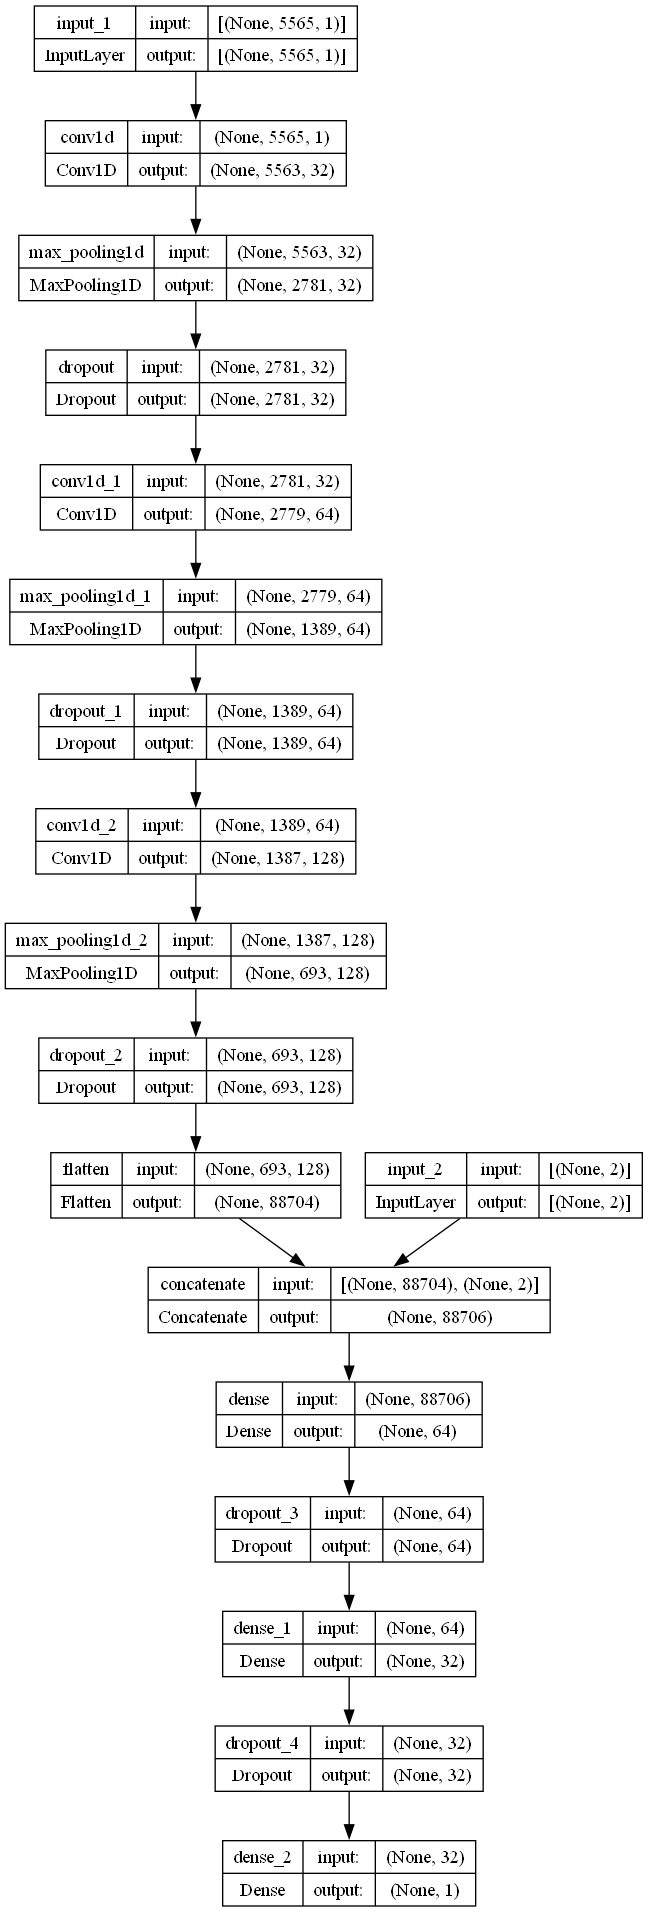

In [3]:

# Define CNN for seismogram input
def create_seismogram_model():
    # Seismogram input
    seismogram_input = Input(shape=(5565, 1))
    
    # Convolutional layers for seismogram data
    x = Conv1D(filters=32, kernel_size=3, activation='relu')(seismogram_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    # Flatten the convolutional layer output
    seismogram_output = Flatten()(x)
    
    return seismogram_input, seismogram_output

# Define auxiliary inputs for standard deviation and other values
def create_aux_input():
    # Auxiliary input (standard deviation, other values)
    aux_input = Input(shape=(2,))
    return aux_input

# Combine seismogram and auxiliary inputs
def create_combined_model():
    # Get seismogram and auxiliary models
    seismogram_input, seismogram_output = create_seismogram_model()
    aux_input = create_aux_input()
    
    # Concatenate seismogram and auxiliary inputs
    combined = concatenate([seismogram_output, aux_input])
    
    # Fully connected layers
    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.4)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.4)(x)
    
    # Output layer (binary classification)
    output = Dense(1, activation='sigmoid')(x)
    
    # Define the complete model
    model = Model(inputs=[seismogram_input, aux_input], outputs=output)
    
    # Compile the model
    opt = Adam(learning_rate=0.0002)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
model = create_combined_model()

# Summary of the model
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)


In [4]:
import numpy as np
# Load the data back into your new environment
X_data = np.load('./data/lunar/training/catalogs/X_data.npy')
y_labels = np.load('./data/lunar/training/catalogs/y_labels.npy')
aux_data = np.load('./data/lunar/training/catalogs/aux_data.npy')
print(f"Data shape: {X_data.shape}, Labels shape: {y_labels.shape}, Aux data shape: {aux_data.shape}")


Data shape: (589, 5565), Labels shape: (589,), Aux data shape: (589, 2)


In [5]:
# Define class weights to balance true (1) and false (0) events
class_weight = {0: 1.0, 1: 6.7}  # 76 true events, 514 false events, adjust as necessary

# Train the model
history = model.fit(
    [X_data, aux_data],  # Inputs: seismogram data and auxiliary inputs
    y_labels,                  # Labels: true or false event
    epochs=50,          # Number of epochs
    batch_size=32,      # Batch size, change if necessary based on memory limits
    validation_split=0.2,  # Use 20% of the data for validation
    class_weight=class_weight  # Adjust class weights to handle imbalance
)

Epoch 1/50
15/15 [==============================] - 3s 95ms/step - loss: 1.1295 - accuracy: 0.7325 - val_loss: 0.4976 - val_accuracy: 0.7712
Epoch 2/50
15/15 [==============================] - 1s 60ms/step - loss: 0.7300 - accuracy: 0.8429 - val_loss: 0.3306 - val_accuracy: 0.8814
Epoch 3/50
15/15 [==============================] - 1s 61ms/step - loss: 0.6215 - accuracy: 0.8429 - val_loss: 0.3918 - val_accuracy: 0.8644
Epoch 4/50
15/15 [==============================] - 1s 60ms/step - loss: 0.5981 - accuracy: 0.8386 - val_loss: 0.3447 - val_accuracy: 0.8898
Epoch 5/50
15/15 [==============================] - 1s 60ms/step - loss: 0.5958 - accuracy: 0.8769 - val_loss: 0.3499 - val_accuracy: 0.8898
Epoch 6/50
15/15 [==============================] - 1s 61ms/step - loss: 0.5088 - accuracy: 0.9087 - val_loss: 0.3013 - val_accuracy: 0.8983
Epoch 7/50
15/15 [==============================] - 1s 61ms/step - loss: 0.4682 - accuracy: 0.9045 - val_loss: 0.3204 - val_accuracy: 0.8983
Epoch 8/50
15

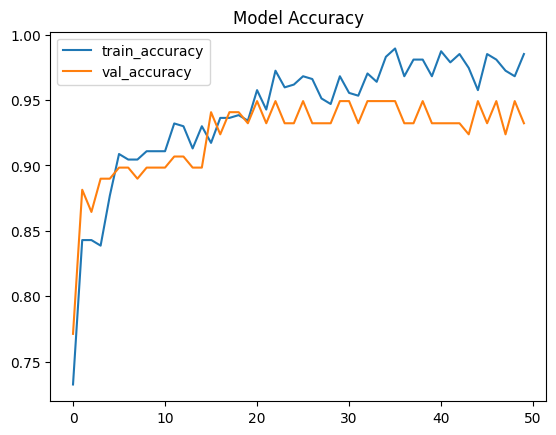

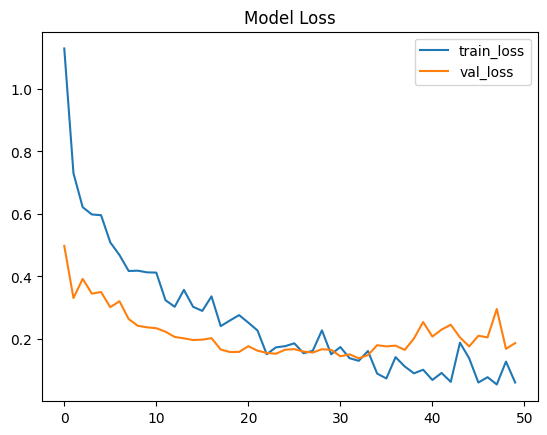

In [6]:
# Visualize training performance
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [8]:
model.save('CNN_model_files/cnn_model_2.h5')  # This will save the model in HDF5 format
print("Model saved to 'seismogram_cnn_model.h5'")

Model saved to 'seismogram_cnn_model.h5'


In [7]:
# # Example of evaluating on a test set (if you have a separate test set)
# # Assuming X_test_seismo and X_test_aux contain test data, and y_test contains test labels
# test_loss, test_accuracy = model.evaluate([X_test_seismo, X_test_aux], y_test)
# print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

NameError: name 'X_test_seismo' is not defined